# Proper Rainbow Saturation for $C_6$

This is a notebook accompanying paper
*Proper Rainbow Saturation Numbers for Cycles*
by Anastasia Halfpap, Bernard Lidický and Tomáš Masařík.

This notebook should be used in SageMath, it is not a usual python notebook.

Call *Core* $K_8$ without an induced matching. 
*Pendant* is a triangle outside of the core connected by 4 edges to the core.
See paper for description of the connection.
We consider Core and two pendant triangles. 

When exploring the colorings, we need to fix the maximum number of colors.
Fortunately we can show that the number of colors is at most 13 in all cases
we need to check.
To make the calculation feasible, we try to fix colors of edges instead of having them as variables.

The first obvious thing to fix is take the vertex of hihgest degree and fix colors of all incident edges. They must be all different since the coloring is rainbow.
Then we proceed as follows.


1) Show that Core can be colored by **at most** 7 colors, meaning 6 or 7 colors.
- First calculate that the largest C6-free subgraph of the core has 15 edges
- Try to color the core with up to 15 colors
- Only colorings with 6 or 7 colors are possible

2) Show that Core and one pendant triangle can be colored by **at most** 9 colors, meaning 8 or 9 colors.
- Core has at most 7 colors
- Extra triangle has 7 edges
- Try up to 14 colors

3) Show that in every coloring of Core and one pendant triangle, colors of some edges are fixed. 
- Makes other programs smaller

4) Show that Core and two pendant triangles can be colored by **at most** 12 colors. 
- Core is at least 6 colors
- Adding a triangle adds aat most 3 new colors
- We do a test on 13 just for sanity check

5) Show that in every coloring of Core and two pendant triangle, colors of few more edges 
are fixed. 

6) Show that no edge can be added to the Core and two pendant triangles. 

7) Show that a core + 1 extra vertex incident to the highest degree vertex is saturated, i.e. no edge can be added.

**Note**: The code can use various solvers. Change the solver in the next cell if you wish.
The calculation of all cells with `calculate_all=False` takes several hours to finish on a laptop. If you set `calculate_all=True`, then you obtain the actual proof but the calculation will require significant memory and would be wise to run on a server instead.

In [1]:
calculate_all = False

# This cell defines functions we use in the rest

# Our Sage was doing a lot of warnings so this turns them off
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# There are two solver so choose from that we tried.
from sage.sat.solvers.picosat import PicoSAT
from sage.sat.solvers.dimacs import Glucose

def sat_test(g, colors, precolored=dict(), forbcolor=dict(), verbose=False, force_use_all_colors=False):
    # precolored are pairs (u,v), color 
    # FOr example {(0,1):1], (0,2):2, ... }
    # g ... Graph
    # colors ... integer, number of colors 0,1,2,...(colors-1)
    # precolored ... recolroing of some edges in g : precolored[(0,1)] = 3
    # forbcolor ... forbidden colors   
    # verbose ... will say more about what isw happening
    # force_use_all_colors ... saying each color must be used
    #
    # return True if coloring exists
    #        False if coloring does not exist
    

    # Here you can change the SAT solver. There are other in SageMath that could
    # be used but we have not tried them.
    solver = PicoSAT()
    #solver = Glucose()

    rainbow_colors=range(colors)  # [0,1,...,colors-1]

    edges = g.edges(labels=False)
    vertices = g.vertices()

    edge_to_variable=dict()
    next_edge=1
    for e in edges:
        edge_to_variable[e]=next_edge
        next_edge += len(rainbow_colors)

    for e in edges:
        if e not in forbcolor:
            forbcolor[e]=[]

    
    # Every edge has at least one color
    for e in edges:
        if e in precolored:
            solver.add_clause([edge_to_variable[e]+precolored[e]]) 
            if verbose:
                print('edge is colored',e,precolored[e])
        else:
            if e in forbcolor:
                solver.add_clause([edge_to_variable[e]+c for c in set(rainbow_colors)-set(forbcolor[e])]) 

                
    # Every color is used
    # AND Every edge has at MOST one color
    if force_use_all_colors:
        for c in set(rainbow_colors):
            #print('Force color',c,'as',[[e,edge_to_variable[e]+c] for e in edges])
            solver.add_clause([edge_to_variable[e]+c for e in edges])
        for e in edges:
            for c in Combinations(set(rainbow_colors),2):
                solver.add_clause((-(edge_to_variable[e]+c[0]), -(edge_to_variable[e]+c[1])))  

                
    # For every two edges sharing a vertex add a clause
    # that the must be of different color
    for x,y in Combinations(edges, 2):
            if set(x) & set(y):
                if x in precolored:
                    xy_colors=[precolored[x]]
                elif y in precolored:
                    xy_colors=[precolored[y]]
                else:
                    xy_colors = set(rainbow_colors) - set(forbcolor[x]) - set(forbcolor[y])
                for c in xy_colors:
                    solver.add_clause((-(edge_to_variable[x]+c), -(edge_to_variable[y]+c)))  
    
    # Now we add all 6-cycles
    for v1 in vertices:
        for v2 in g.neighbors(v1):
            if v1 > v2:
                continue
            for v3 in g.neighbors(v2):
                if v1 >= v3:
                    continue
                for v4 in g.neighbors(v3):
                    if v1 >= v4 or v4 == v2:
                        continue
                    for v5 in g.neighbors(v4):
                        if v1 >= v5 or v5 in [v2,v3]:
                            continue
                        for v6 in set(g.neighbors(v5)) & set(g.neighbors(v1)):
                            if v6 < v1 or v6 <= v2 or v6 in [v3,v4]:
                                continue                              
                            # finally v1,...,v6 is a 6-cycle
                            # Not any rainbow cycle
                            # ¬(P ∧ Q ∧ R) ∧ ¬(P ∧ Q ∧ S) ∧ ¬(T ∧ Q ∧ R) ∧ ¬(T ∧ Q ∧ S) ∧ ¬(P ∧ U ∧ R) ∧ ¬(P ∧ U ∧ S) ∧ ¬(T ∧ U ∧ R) ∧ ¬(T ∧ U ∧ S)
                            # (¬P ∨ ¬Q ∨ ¬R) ∧ (¬P ∨ ¬Q ∨ ¬S) ∧ (¬T ∨ ¬Q ∨ ¬R) ∧ (¬T ∨ ¬Q ∨ ¬S) ∧ (¬P ∨ ¬U ∨ ¬R) ∧ (¬P ∨ ¬U ∨ ¬S) ∧ (¬T ∨ ¬U ∨ ¬R) ∧ (¬T ∨ ¬U ∨ ¬S) 
                            # Go over all rainbow colorings
                            eC6 = [ (min(u,v), max(u,v)) for u,v in [[v1,v2],[v2,v3],[v3,v4],[v4,v5],[v5,v6],[v1,v6]] ]
                            
                            interesting=False;
                            #if v1 == 0 and v2 == 2 and v3 == 5 and v4 == 1 and v5 == 10 and v6 == 9:
                            #    interesting = True
                            
                            if interesting:
                                print("FOUND",eC6)
                            if verbose:
                                print('6-cycle',eC6)
                                print(v1, v2, v3, v4, v5, v6)
                            fixed_eC6 = [e for e in eC6 if e in precolored ]
                            forced_colors = [ precolored[e] for e in fixed_eC6 ]
                            
                            # C6 is definitely not rainbow
                            if len(forced_colors) > len(set(forced_colors)):
                                continue
                                
                            rainbows_for_eC6 = set(rainbow_colors) - set(forced_colors)
                            free_eC6 = list(set(eC6) - set(fixed_eC6))
                            
                            if len(rainbows_for_eC6) < len(free_eC6):
                                print('Something went wrong')

                            if interesting:
                                print('  Color so far')
                                print('fixed_eC6=',fixed_eC6)
                                print('forced_colors=',forced_colors)
                                print('rainbows_for_eC6=',rainbows_for_eC6)
                                print('free_eC6=',free_eC6)
                            
                            for rainbow in Permutations(rainbows_for_eC6, len(free_eC6)):
                                
                                # not allowed colors
                                colors_allowed=True
                                for i in range(len(free_eC6)):
                                    if rainbow[i] in forbcolor[free_eC6[i]]:
                                        colors_allowed = False
                                        break
                                if colors_allowed == False:
                                    continue
                                
                                solver.add_clause([  -(edge_to_variable[free_eC6[i]]+rainbow[i]) for i in range(len(free_eC6))])
                                if verbose >= 2:
                                    print('  Avoid',[ [free_eC6[i], rainbow[i]]   for i in range(len(free_eC6)) ])

  
    print('SAT with',len(solver.clauses()),'clauses')
    #print(solver.clauses())
    solution= solver()
    if solution != False:
        for e in edges:
            init = edge_to_variable[e]
            for c in rainbow_colors:
                if solution[init+c] == True:
                    g.set_edge_label(e[0],e[1], c)
                    #print(e[0],e[1], c)
    #print('Solution is',solution)
    
    return solution != False
                

    
def test_if_precoloring_ok(g):
    # g  graph
    # Assume each edge, has a label that is it's color
    # This test if there is no rainbow 6-cycle
    
    vertices = g.vertices()
    edges = g.edges()

    # Test if the coloring is proper
    for v1 in vertices:
        for v2 in g.neighbors(v1):
            for v3 in g.neighbors(v2):
                if v1 >= v3:
                    continue
                labels = [ g.edge_label(v1, v2), g.edge_label(v2, v3)]
                if '' in labels: continue
                if len(set(labels)) != 2:
                    print("Not proper coloring ",[v1,v2],[v2,v3],'Colors are',g.edge_label(v1, v2), g.edge_label(v2, v3))

    # Now we add all 6-cycles
    for v1 in vertices:
        for v2 in g.neighbors(v1):
            if v1 > v2:
                continue
            for v3 in g.neighbors(v2):
                if v1 >= v3:
                    continue
                for v4 in g.neighbors(v3):
                    if v1 >= v4 or v4 == v2:
                        continue
                    for v5 in g.neighbors(v4):
                        if v1 >= v5 or v5 in [v2,v3]:
                            continue
                        for v6 in set(g.neighbors(v5)) & set(g.neighbors(v1)):
                            if v6 < v1 or v6 <= v2 or v6 in [v3,v4]:
                                continue                              
                            # finally v1,...,v6 is a 6-cycle
                            # Not any rainbow cycle
                            # ¬(P ∧ Q ∧ R) ∧ ¬(P ∧ Q ∧ S) ∧ ¬(T ∧ Q ∧ R) ∧ ¬(T ∧ Q ∧ S) ∧ ¬(P ∧ U ∧ R) ∧ ¬(P ∧ U ∧ S) ∧ ¬(T ∧ U ∧ R) ∧ ¬(T ∧ U ∧ S)
                            # (¬P ∨ ¬Q ∨ ¬R) ∧ (¬P ∨ ¬Q ∨ ¬S) ∧ (¬T ∨ ¬Q ∨ ¬R) ∧ (¬T ∨ ¬Q ∨ ¬S) ∧ (¬P ∨ ¬U ∨ ¬R) ∧ (¬P ∨ ¬U ∨ ¬S) ∧ (¬T ∨ ¬U ∨ ¬R) ∧ (¬T ∨ ¬U ∨ ¬S) 
                            # Go over all rainbow colorings
                            eC6 = [ (min(u,v), max(u,v)) for u,v in [[v1,v2],[v2,v3],[v3,v4],[v4,v5],[v5,v6],[v1,v6]] ]

                            labels = [ g.edge_label(u, v) for u,v in eC6]
                            if '' in labels: continue
                            if None in labels: continue
                            if len(set(labels)) == 6:
                                print("Rainbow C6",eC6)
        
def can_add_edge(g, colors, precolor, forb, e):
    # Test if edge e can be added to graph g
    #
    #
    g_e = copy(g)
    g_e.add_edge(e)
    e_forb = copy(forb)
    expand_forb_from_precolor(g_e, precolor, e_forb)
    solution=sat_test(g_e, colors, precolor, e_forb, 0)
    if solution == False:
        print(e,'--- cannot be added')
    else:
        print(e,'+++    can be added')
    return solution

def label_graph(g, precolor, forb):
    # Adds labels to the edges
    # 
    for e in g.edges():
        g.set_edge_label(e[0],e[1], '')
    for e in forb:
        g.set_edge_label(e[0],e[1], '!')
        #g.set_edge_label(e[0],e[1], '!'+str(forb[e]))
    for e in precolor:
        g.set_edge_label(e[0],e[1], precolor[e])


def expand_forb_from_precolor(g, precolor, forb):
    # Makes sure that forb includes colors of incident edges that are precolored
    #

    for e, color_e in precolor.items():
        for u in e[:2]:
            for v in g.neighbors(u):
                e_uv = (min(u,v),max(u,v))
                if e_uv not in precolor:
                    if e_uv in forb:
                        forb[e_uv].append(color_e)
                    else:
                        forb[e_uv] = [color_e]


def is_c_forced_on_e(g, colors, precolor, forb, e, c):
    # If coloring without e being colored c is possible
    # it will be in labels of g
    forb_e= forb
    if e in forb:
        forb_e[e].append(c)
    else:
        forb_e[e] = [c]
    expand_forb_from_precolor(g, precolor, forb_e)
    solution=sat_test(g, colors, precolor, forb_e)
    if solution == False:
        print(e,'Must be colored by ',c)
    else:
        print(e,'can be colored without',c)


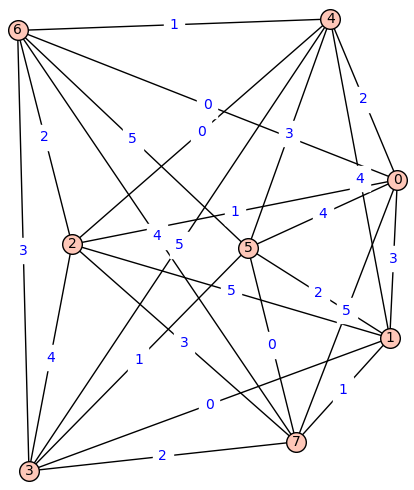

Testing core.....
Maximum number of edges in a C6-free subgraphs of the core is 15.0
Maximum number of colors core could be rainbow colored is 15.0
SAT with 20939 clauses
6-Coloring exists  True
SAT with 177831 clauses
7-Coloring exists  True
SAT with 845803 clauses
8-Coloring exists  False
SAT with 2924759 clauses
9-Coloring exists  False
SAT with 8220075 clauses
10-Coloring exists  False
Set calculate_all=True to test the 11- to 15- colorings
Done with core


In [17]:
# This cell tests Core 
#
# To get the drawing, we used 
#
#  from phitigra import GraphEditor
# 
#   editor = GraphEditor(g)
#   editor.show()
#
# This works in jupyter notebook

# can be obtained as g.get_pos()
pos={0: (340, -150),
 1: (334, -275),
 2: (83, -201),
 3: (49, -380),
 4: (287, -23),
 5: (222, -204),
 6: (40, -32),
 7: (260, -357),
    }

# can be obtained as g.edges()
edges=[(0, 1, 3), (0, 2, 1), (0, 4, 2), (0, 5, 4), (0, 6, 0), (0, 7, 5),  (1, 2, 5), (1, 3, 0), (1, 4, 4), (1, 5, 2), (1, 7, 1),  (2, 3, 4), (2, 4, 0), (2, 6, 2), (2, 7, 3), (3, 4, 5), (3, 5, 1), (3, 6, 3), (3, 7, 2), (4, 5, 3), (4, 6, 1), (5, 6, 5), (5, 7, 0), (6, 7, 4)]


g=Graph(edges)
g.set_pos(pos)

g.graphplot(edge_labels=True).show(figsize=[8, 5])

# This will complain if rainbow C6 exists
test_if_precoloring_ok(g)


precolor = {
    (0,1):3, (1,2):5, (1,3):0, (1,4):4, (1,5):2, (1,7):1
        }


forb=dict()
expand_forb_from_precolor(g, precolor, forb)
 
print('Testing core.....')
# Colorable with 9 colors


edges = g.edges(labels=False)
vertices = g.vertices()


# Testing maximum number of colors needed 
p = MixedIntegerLinearProgram(maximization=True, solver="GLPK")    
x = p.new_variable(binary=True)
p.set_objective(sum([x[e] for e in edges]))

# Now we add all 6-cycles
for v1 in vertices:
    for v2 in g.neighbors(v1):
        if v1 > v2:
            continue
        for v3 in g.neighbors(v2):
            if v1 >= v3:
                continue
            for v4 in g.neighbors(v3):
                if v1 >= v4 or v4 == v2:
                    continue
                for v5 in g.neighbors(v4):
                    if v1 >= v5 or v5 in [v2,v3]:
                        continue
                    for v6 in set(g.neighbors(v5)) & set(g.neighbors(v1)):
                        if v6 < v1 or v6 <= v2 or v6 in [v3,v4]:
                            continue                


                        # finally v1,...,v6 is a 6-cycle
                        # Not any rainbow cycle
                        # ¬(P ∧ Q ∧ R) ∧ ¬(P ∧ Q ∧ S) ∧ ¬(T ∧ Q ∧ R) ∧ ¬(T ∧ Q ∧ S) ∧ ¬(P ∧ U ∧ R) ∧ ¬(P ∧ U ∧ S) ∧ ¬(T ∧ U ∧ R) ∧ ¬(T ∧ U ∧ S)
                        # (¬P ∨ ¬Q ∨ ¬R) ∧ (¬P ∨ ¬Q ∨ ¬S) ∧ (¬T ∨ ¬Q ∨ ¬R) ∧ (¬T ∨ ¬Q ∨ ¬S) ∧ (¬P ∨ ¬U ∨ ¬R) ∧ (¬P ∨ ¬U ∨ ¬S) ∧ (¬T ∨ ¬U ∨ ¬R) ∧ (¬T ∨ ¬U ∨ ¬S) 
                        # Go over all rainbow colorings
                        eC6 = [ (min(u,v), max(u,v)) for u,v in [[v1,v2],[v2,v3],[v3,v4],[v4,v5],[v5,v6],[v1,v6]] ]

                        p.add_constraint(sum([x[e] for e in eC6]) <= 5)
max_edges=p.solve()
print('Maximum number of edges in a C6-free subgraphs of the core is',max_edges)
print('Maximum number of colors core could be rainbow colored is',max_edges)


# Can be colored with 9 colors
solution=sat_test(g, 6, precolor, forb, 0, True)
print('6-Coloring exists ',solution)

solution=sat_test(g, 7, precolor, forb, 0, True)
print('7-Coloring exists ',solution)

# All these below also result is False but the computation
# starts to take a long time
solution=sat_test(g, 8, precolor, forb, 0, True)
print('8-Coloring exists ',solution)

solution=sat_test(g, 9, precolor, forb, 0, True)
print('9-Coloring exists ',solution)

solution=sat_test(g, 10, precolor, forb, 0, True)
print('10-Coloring exists ',solution)

if calculate_all:
    solution=sat_test(g, 11, precolor, forb, 0, True)
    print('11-Coloring exists ',solution)

    solution=sat_test(g, 12, precolor, forb, 0, True)
    print('12-Coloring exists ',solution)

    solution=sat_test(g, 13, precolor, forb, 0, True)
    print('13-Coloring exists ',solution)

    solution=sat_test(g, 14, precolor, forb, 0, True)
    print('14-Coloring exists ',solution)

    solution=sat_test(g, 15, precolor, forb, 0, True)
    print('15-Coloring exists ',solution)
    
else:
    print("Set calculate_all=True to test the 11- to 15- colorings")
    
print('Done with core')

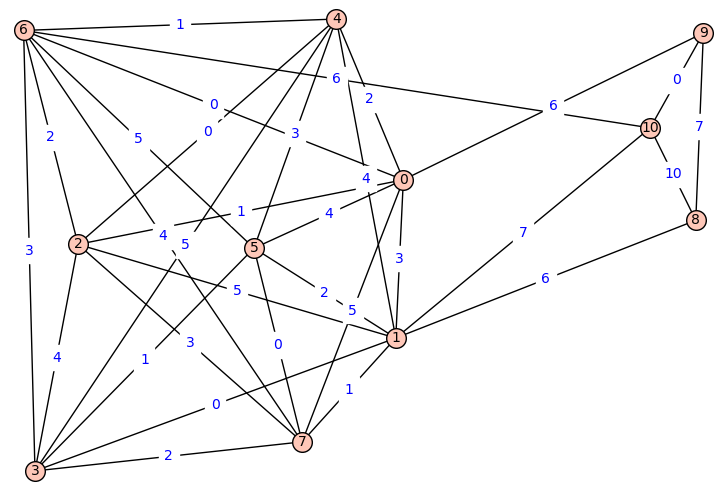

Testing core + 1 triangle...
SAT with 250759 clauses
8-Coloring exists  True
SAT with 334463 clauses
9-Coloring exists  True
SAT with 473410 clauses
10-Coloring exists  False
Set calculate_all=True to test the 11- to 14- colorings
SAT with 3303997 clauses
(6, 10) Must be colored by  6
SAT with 2397901 clauses
coloring of edge (0,9) without using 6 or 7 existence:  False


In [18]:
# This cell tests Core plus one pendant triangle.
#
#
# To get the drawing, we used 
#
#  from phitigra import GraphEditor
# 
#   editor = GraphEditor(g)
#   editor.show()
#
# This works in jupyter notebook

# can be obtained as g.get_pos()
pos={0: (340, -150),
 1: (334, -275),
 2: (83, -201),
 3: (49, -380),
 4: (287, -23),
 5: (222, -204),
 6: (40, -32),
 7: (260, -357),
 8: (571, -182),
 9: (577, -34),
 10: (535, -109),
    }

# can be obtained as g.edges()
edges=[(0, 1, 3), (0, 2, 1), (0, 4, 2), (0, 5, 4), (0, 6, 0), (0, 7, 5), (0, 9, 6),  (1, 2, 5), (1, 3, 0), (1, 4, 4), (1, 5, 2), (1, 7, 1), (1, 8, 6), (1, 10, 7), (2, 3, 4), (2, 4, 0), (2, 6, 2), (2, 7, 3), (3, 4, 5), (3, 5, 1), (3, 6, 3), (3, 7, 2), (4, 5, 3), (4, 6, 1), (5, 6, 5), (5, 7, 0), (6, 7, 4), (6, 10, 6), (8, 9, 7), (8, 10, 10), (9, 10, 0)]


g=Graph(edges)
g.set_pos(pos)

g.graphplot(edge_labels=True).show(figsize=[8, 5])

# This will complain if rainbow C6 exists
test_if_precoloring_ok(g)


precolor = {
    (0,1):3, (1,2):5, (1,3):0, (1,4):4, (1,5):2, (1,7):1, (1,8):6, (1,10):7
        }

forb=dict()
for e in g.edges(labels=False):
    if max(e) <= 7:
        forb[e] = [7,8,9,10,11,12,13,14]


expand_forb_from_precolor(g, precolor, forb)
 
print('Testing core + 1 triangle...')
# Colorable with 9 colors

# Can be colored with 8 colors
solution=sat_test(g, 8, precolor, forb, 0, True)
print('8-Coloring exists ',solution)


# Can be colored with 9 colors
solution=sat_test(g, 9, precolor, forb, 0, True)
print('9-Coloring exists ',solution)

# CANNOT be colored with 10 colors
solution=sat_test(g, 10, precolor, forb, 0, True)
print('10-Coloring exists ',solution)

if calculate_all:
    # CANNOT be colored with 11 colors
    solution=sat_test(g, 11, precolor, forb, 0, True)
    print('11-Coloring exists ',solution)

    solution=sat_test(g, 12, precolor, forb, 0, True)
    print('12-Coloring exists ',solution)

    solution=sat_test(g, 13, precolor, forb, 0, True)
    print('13-Coloring exists ',solution)

    solution=sat_test(g, 14, precolor, forb, 0, True)
    print('14-Coloring exists ',solution)
else:
    print("Set calculate_all=True to test the 11- to 14- colorings")
    

#g.graphplot(edge_labels=True).show(figsize=[8, 5])


is_c_forced_on_e(g, 9, precolor, dict(), (6,10), 6)
precolor[(6,10)]=6


# This is saying (0,9) must be colored 6 or 7
forb=dict()
forb[(0,9)] = [6,7]
expand_forb_from_precolor(g, precolor, forb)
solution=sat_test(g, 9, precolor, forb, 0, True)
print('coloring of edge (0,9) without using 6 or 7 existence: ', solution)


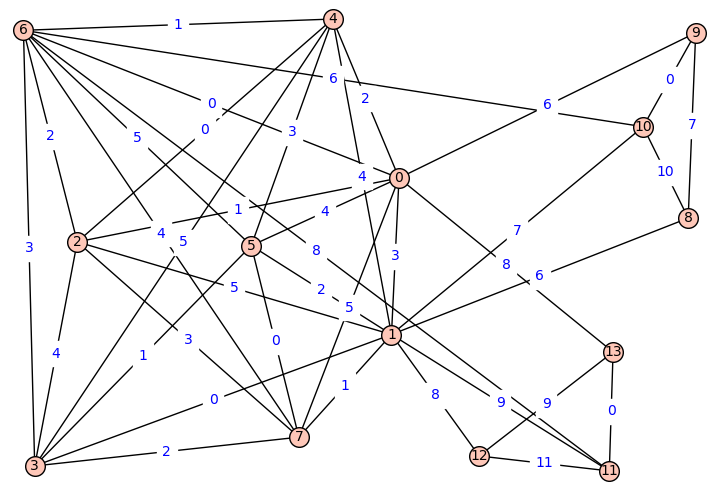

Testing core + 2 triangles ...
SAT with 30757570 clauses
12-Coloring exists  True
SAT with 62965204 clauses
13-Coloring exists  False
WLOG we can restrict to 12 colors for exploring the coloring.
WLOG we can restrict to 13 colors for tests of adding one extra edge.


In [3]:
# This Cell shows that core and two pendant triangles can be colored by at most 12 colors. 
# This will run for a while, say an hour.
#
# can be obtained as g.get_pos()
pos={0: (340, -150),
 1: (334, -275),
 2: (83, -201),
 3: (49, -380),
 4: (287, -23),
 5: (222, -204),
 6: (40, -32),
 7: (260, -357),
 8: (571, -182),
 9: (577, -34),
 10: (535, -109),
 11: (508, -384),
 12: (404, -372),
 13: (511, -289)}

# can be obtained as g.edges()
edges=[(0, 1, 3), (0, 2, 1), (0, 4, 2), (0, 5, 4), (0, 6, 0), (0, 7, 5), (0, 9, 6), (0, 13, 8), (1, 2, 5), (1, 3, 0), (1, 4, 4), (1, 5, 2), (1, 7, 1), (1, 8, 6), (1, 10, 7), (1, 11, 9), (1, 12, 8), (2, 3, 4), (2, 4, 0), (2, 6, 2), (2, 7, 3), (3, 4, 5), (3, 5, 1), (3, 6, 3), (3, 7, 2), (4, 5, 3), (4, 6, 1), (5, 6, 5), (5, 7, 0), (6, 7, 4), (6, 10, 6), (6, 11, 8), (8, 9, 7), (8, 10, 10), (9, 10, 0), (11, 12, 11), (11, 13, 0), (12, 13, 9)]


g=Graph(edges)
g.set_pos(pos)

g.graphplot(edge_labels=True).show(figsize=[8, 5])

# This will complain if rainbow C6 exists
test_if_precoloring_ok(g)



precolor = {
    (0,1):3, (1,2):5, (1,3):0, (1,4):4, (1,5):2, (1,7):1,
    (1,8):6, (1,10):7, 
    (1,11):9, (1,12):8,
    (6,10):6, (6,11):8,
           }


forb=dict()
forb[(0,9)]  = [0,1,2,3,4,5,  8,9,10,11,12]
forb[(0,13)] = [0,1,2,3,4,5,6,7, 10,11,12]
expand_forb_from_precolor(g, precolor, forb)


print('Testing core + 2 triangles ...')
# 12-coloring exists
solution=sat_test(g, 12, precolor, forb, 0, True)
print('12-Coloring exists ',solution)
solution=sat_test(g, 13, precolor, forb, 0, True)
print('13-Coloring exists ',solution)

print('WLOG we can restrict to 12 colors for exploring the coloring.')
print('WLOG we can restrict to 13 colors for tests of adding one extra edge.')

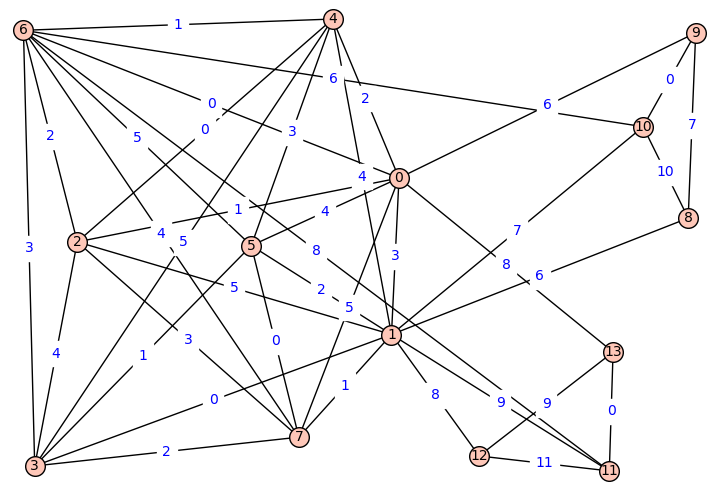

Testing core + 2 triangles ...
SAT with 30747262 clauses
(0, 9) Must be colored by  6
SAT with 20951123 clauses
(0, 6) Must be colored by  0
SAT with 24138486 clauses
(11, 0) --- cannot be added
SAT with 24660625 clauses
(11, 2) --- cannot be added
SAT with 24729607 clauses
(11, 3) --- cannot be added
SAT with 24660625 clauses
(11, 4) --- cannot be added
SAT with 24660625 clauses
(11, 5) --- cannot be added
SAT with 24660625 clauses
(11, 7) --- cannot be added
SAT with 23479491 clauses
(11, 8) --- cannot be added
SAT with 23500675 clauses
(11, 9) --- cannot be added
SAT with 23493925 clauses
(11, 10) --- cannot be added
SAT with 24018695 clauses
(12, 0) --- cannot be added
SAT with 24607252 clauses
(12, 2) --- cannot be added
SAT with 24846472 clauses
(12, 3) --- cannot be added
SAT with 24607252 clauses
(12, 4) --- cannot be added
SAT with 24607252 clauses
(12, 5) --- cannot be added
SAT with 24193092 clauses
(12, 6) --- cannot be added
SAT with 24607252 clauses
(12, 7) --- cannot be 

In [4]:
# This Cell shows that core and two pendant triangles have some colors fixed
# and no other edges can be added. Runs over several hours on a laptop.

# can be obtained as g.get_pos()
pos={0: (340, -150),
 1: (334, -275),
 2: (83, -201),
 3: (49, -380),
 4: (287, -23),
 5: (222, -204),
 6: (40, -32),
 7: (260, -357),
 8: (571, -182),
 9: (577, -34),
 10: (535, -109),
 11: (508, -384),
 12: (404, -372),
 13: (511, -289)}

# can be obtained as g.edges()
edges=[(0, 1, 3), (0, 2, 1), (0, 4, 2), (0, 5, 4), (0, 6, 0), (0, 7, 5), (0, 9, 6), (0, 13, 8), (1, 2, 5), (1, 3, 0), (1, 4, 4), (1, 5, 2), (1, 7, 1), (1, 8, 6), (1, 10, 7), (1, 11, 9), (1, 12, 8), (2, 3, 4), (2, 4, 0), (2, 6, 2), (2, 7, 3), (3, 4, 5), (3, 5, 1), (3, 6, 3), (3, 7, 2), (4, 5, 3), (4, 6, 1), (5, 6, 5), (5, 7, 0), (6, 7, 4), (6, 10, 6), (6, 11, 8), (8, 9, 7), (8, 10, 10), (9, 10, 0), (11, 12, 11), (11, 13, 0), (12, 13, 9)]


g=Graph(edges)
g.set_pos(pos)

g.graphplot(edge_labels=True).show(figsize=[8, 5])

# This will complain if rainbow C6 exists
test_if_precoloring_ok(g)


precolor = {
    (0,1):3, (1,2):5, (1,3):0, (1,4):4, (1,5):2, (1,7):1,
    (1,8):6, (1,10):7, 
    (1,11):9, (1,12):8
           }


for e in g.edges():
    g.set_edge_label(e[0],e[1], '')
for e in precolor:
    g.set_edge_label(e[0],e[1], precolor[e])
    
test_if_precoloring_ok(g)
    
#g.graphplot(edge_labels=True).show(figsize=[8, 5])


print('Testing core + 2 triangles ...')

# We know this from before
#is_c_forced_on_e(g, 12, precolor, dict(), (6,10), 6)
precolor[(6,10)]=6
precolor[(6,11)]=8


# We know this from before
forb=dict()
forb[(0,9)]  = [0,1,2,3,4,5,  8,9,10,11,12]
forb[(0,13)] = [0,1,2,3,4,5,6,7, 10,11,12]

is_c_forced_on_e(g, 12, precolor, forb, (0,9), 6)
precolor[(0,9)]=6
precolor[(0,13)]=8


is_c_forced_on_e(g, 12, precolor, dict(), (0,6), 0)
precolor[(0,6)]=0




# Tests of addition of extra edge to the construction

for u in [11,12,13]:
    for v in range(11):
        if v not in g.neighbors(u):
            can_add_edge(g, 13, precolor, dict(), (u,v))

can_add_edge(g, 13, precolor, dict(), (2,5))
can_add_edge(g, 13, precolor, dict(), (1,6))
can_add_edge(g, 13, precolor, dict(), (0,3))
can_add_edge(g, 13, precolor, dict(), (4,7))
print("Proof is done")

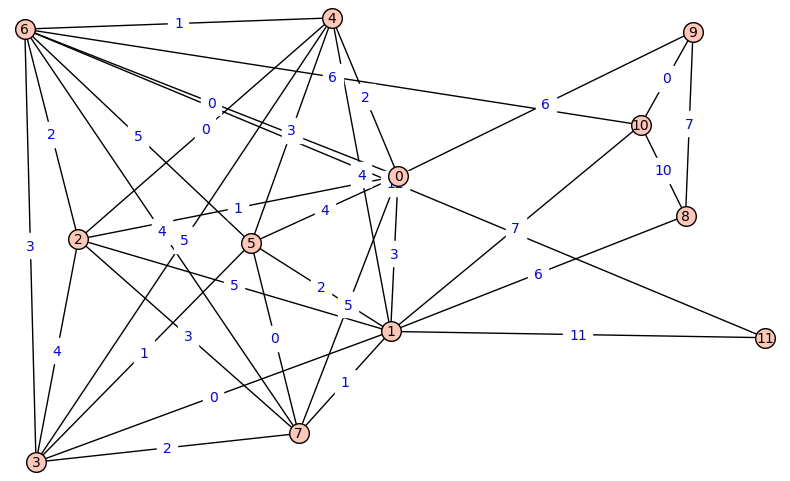

Testing core + 1 triangle +1 vertex...
SAT with 18595852 clauses
(11, 0) --- cannot be added
SAT with 19247981 clauses
(11, 2) --- cannot be added
SAT with 18475812 clauses
(11, 3) --- cannot be added
SAT with 19247981 clauses
(11, 4) --- cannot be added
SAT with 19247981 clauses
(11, 5) --- cannot be added
SAT with 19247981 clauses
(11, 7) --- cannot be added
SAT with 15857155 clauses
(11, 8) --- cannot be added
SAT with 15963827 clauses
(11, 9) --- cannot be added
SAT with 15829094 clauses
(11, 10) --- cannot be added


In [2]:
# This cell tests Core plus one pendant triangle.
#
#
# To get the drawing, we used 
#
#  from phitigra import GraphEditor
# 
#   editor = GraphEditor(g)
#   editor.show()
#
# This works in jupyter notebook

# can be obtained as g.get_pos()
pos={0: (340, -150),
 1: (334, -275),
 2: (83, -201),
 3: (49, -380),
 4: (287, -23),
 5: (222, -204),
 6: (40, -32),
 7: (260, -357),
 8: (571, -182),
 9: (577, -34),
 10: (535, -109),
 11: (635, -280),
    }

# can be obtained as g.edges()
edges=[(0, 1, 3), (0, 2, 1), (0, 4, 2), (0, 5, 4), (0, 6, 0), (0, 7, 5), (0, 9, 6),  (1, 2, 5), (1, 3, 0), (1, 4, 4), (1, 5, 2), (1, 7, 1), (1, 8, 6), (1, 10, 7), (2, 3, 4), (2, 4, 0), (2, 6, 2), (2, 7, 3), (3, 4, 5), (3, 5, 1), (3, 6, 3), (3, 7, 2), (4, 5, 3), (4, 6, 1), (5, 6, 5), (5, 7, 0), (6, 7, 4), (6, 10, 6), (8, 9, 7), (8, 10, 10), (9, 10, 0), (1,11,11), (6,11,12)]


g=Graph(edges)
g.set_pos(pos)

g.graphplot(edge_labels=True).show(figsize=[8, 5])

# This will complain if rainbow C6 exists
test_if_precoloring_ok(g)


precolor = {
    (0,1):3, (1,2):5, (1,3):0, (1,4):4, (1,5):2, (1,7):1, (1,8):6, (1,10):7, (1,11):8
        }

forb=dict()
#for e in g.edges(labels=False):
#    if max(e) <= 7:
#        forb[e] = [7,8,9,10,11,12,13,14]

expand_forb_from_precolor(g, precolor, forb)
 
print('Testing core + 1 triangle +1 vertex...')

precolor[(6,10)]=6
precolor[(0,9)]=6
precolor[(0,6)]=0


for u in [11]:
    for v in range(11):
        if v not in g.neighbors(u):
            can_add_edge(g, 12, precolor, dict(), (u,v))


In [ ]:
if calculate_all:
    print("Proof is done")
else:
    print("Proof most of the proof done.")